<a href="https://colab.research.google.com/github/rohitsharma21791/COVID_Directory/blob/main/Covid_MobileNetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')
!nvidia-smi

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Mon Aug  9 07:18:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

In [2]:
%reset -f

In [ ]:
!unrar x -Y "/content/drive/MyDrive/Gray.rar" "/content/"

In [4]:
import numpy as np
import os
import shutil
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.callbacks import EarlyStopping,CSVLogger
from time import time

In [5]:
##### Import Python Files for Confusion_matrix and Precision and Recall Caluclation
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from distutils.file_util import copy_file
copy_file("/content/drive/MyDrive/Colab Notebooks/make_confusion_matrix.py", "/content/")
copy_file("/content/drive/MyDrive/Colab Notebooks/calc_precision_recall.py", "/content/")

('/content/calc_precision_recall.py', 1)

In [6]:
dir = '/content/Covid_MI'
if os.path.exists(dir):
    shutil.rmtree(dir)
src_dir1='/content/Gray/ECG_covid'
 
dst_dir1 ='/content/Covid_MI'
  
shutil.copytree( src_dir1, dst_dir1)

'/content/Covid_MI'

In [7]:
################## Read the Images and Labels##########################

import tensorflow as tf
from PIL import Image
image_directory = '/content/Covid_MI/'
SIZE =112
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

Covid_images = os.listdir(image_directory + 'ECG Images of COVID-19 Patients (250)/')
for i, image_name in enumerate(Covid_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread((image_directory + 'ECG Images of COVID-19 Patients (250)/' + image_name),0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

MI_images = os.listdir(image_directory + 'ECG Images of Patient that have abnormal heart beats (548)/')
for i, image_name in enumerate(MI_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread((image_directory +  'ECG Images of Patient that have abnormal heart beats (548)/' + image_name),0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

       

dataset = np.array(dataset)
label = np.array(label)



In [86]:
########################## Split train, test and valid ############################
#from keras.utils import to_categorical

X_train1, X_test, y_train1, y_test = train_test_split(dataset,label, test_size = 0.1,random_state = 32,shuffle=True,stratify=label)
X_train, X_val, y_train, y_val=train_test_split(X_train1,y_train1, test_size = 0.1, random_state = 32,shuffle=True,stratify=y_train1)
print(X_train.shape)
print(y_train1.shape)

y_test_label=y_test
#y_test=to_categorical(y_test)
#y_train=to_categorical(y_train)


(644, 112, 112)
(716,)


In [87]:

######## Expand dimension to match with output of the model############
y_train=tf.expand_dims(input=y_train, axis=1)
y_train=tf.expand_dims(input=y_train, axis=1)
y_test=tf.expand_dims(input=y_test, axis=1)
y_test=tf.expand_dims(input=y_test, axis=1)

y_val=tf.expand_dims(input=y_val, axis=1)
y_val=tf.expand_dims(input=y_val, axis=1)

print(X_train.shape)
print(y_test.shape)
print(y_val.shape)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
 rotation_range=0,
 width_shift_range=3,
 height_shift_range=3,
 horizontal_flip=False)

(644, 112, 112)
(80, 1, 1)
(72, 1, 1)


In [88]:

#Without scaling (normalize) the training may not converge. 
#Normalization is a rescaling of the data from the original range 
#so that all values are within the range of 0 and 1.

X_train=np.array(X_train).reshape(-1,SIZE, SIZE,1)
X_train=X_train/255.0
y_train=np.array(y_train).reshape(-1,1)
y_train=tf.expand_dims(input=y_train, axis=1)
y_train=tf.expand_dims(input=y_train, axis=1)


X_val=np.array(X_val).reshape(-1,SIZE, SIZE,1)
X_val=X_val/255.0
y_val=np.array(y_val).reshape(-1,1)
y_val=tf.expand_dims(input=y_val, axis=1)
y_val=tf.expand_dims(input=y_val, axis=1)





X_test=np.array(X_test).reshape(-1,SIZE, SIZE,1)
X_test=X_test/255.0
y_test=np.array(y_test).reshape(-1,1)



y_test=tf.expand_dims(input=y_test, axis=1)
y_test=tf.expand_dims(input=y_test, axis=1)
train_it= datagen.flow(X_train, y_train, batch_size = 32)
Val_it=datagen.flow(X_val, y_val,batch_size=32)




In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug  7 23:33:36 2021

@author: Sharma
"""


from keras.layers import Input
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU, add




from time import time
import numpy as np
import tensorflow as tf


from keras.models import Model

def h_sigmoid(x):
    return tf.nn.relu6(x + 3) / 6

def h_swish(x):
    return x * h_sigmoid(x)

def mobile_netv3(input_shape,n_classes):
    
    def se_block(x1,input_channels,r=16):
        x=GlobalAvgPool2D()(x1)
        x=Dense(units=input_channels//r)(x)
        x=ReLU()(x)
        x=Dense(units=input_channels)(x)
        x=h_sigmoid(x)
        x=tf.expand_dims(input=x, axis=1)
        x=tf.expand_dims(input=x, axis=1)
        
        x=x1*x
        return x
    
    def BottleNeck(x1,in_size,exp_size,out_size,s,is_se_existing,NL,k):
        x=Conv2D(filters=exp_size,kernel_size=(1, 1),strides=1,padding="same")(x1)
        x=BatchNormalization()(x)
        if NL=="HS":
            x=h_swish(x)
        elif NL=="RE":
            x=tf.nn.relu6(x)
        x=DepthwiseConv2D(kernel_size=(k, k),strides=s,padding="same")(x)
        x=BatchNormalization()(x)
        if NL=="HS":
            x=h_swish(x)
        elif NL=="RE":
            x=tf.nn.relu6(x)
        if is_se_existing:
            x=se_block(x,input_channels=exp_size)
        x=Conv2D(filters=out_size,kernel_size=(1, 1),strides=1,padding="same")(x)
        x=BatchNormalization()(x)
        x=Activation(tf.keras.activations.linear)(x)
        if s==1 and in_size==out_size:
            x=add([x,x1])
        return x
    input=Input(input_shape)
    x=Conv2D(filters=16,kernel_size=(3,3),strides=2,padding="same")(input)
    x=BatchNormalization()(x)
    x=BottleNeck(x,in_size=16, exp_size=16, out_size=16, s=2, is_se_existing=True, NL="RE", k=3)
    x=BottleNeck(x,in_size=16, exp_size=72, out_size=24, s=2, is_se_existing=False, NL="RE", k=3)
    x=BottleNeck(x,in_size=24, exp_size=88, out_size=24, s=1, is_se_existing=False, NL="RE", k=3)
    x=BottleNeck(x,in_size=24, exp_size=96, out_size=40, s=2, is_se_existing=True, NL="HS", k=5)
    x=BottleNeck(x,in_size=40, exp_size=240, out_size=40, s=1, is_se_existing=True, NL="HS", k=5)
    x=BottleNeck(x,in_size=40, exp_size=240, out_size=40, s=1, is_se_existing=True, NL="HS", k=5)   
    x=BottleNeck(x,in_size=40, exp_size=120, out_size=48, s=1, is_se_existing=True, NL="HS", k=5)
    x=BottleNeck(x,in_size=48, exp_size=144, out_size=48, s=1, is_se_existing=True, NL="HS", k=5)
    x=BottleNeck(x,in_size=48, exp_size=288, out_size=96, s=2, is_se_existing=True, NL="HS", k=5)
    x=BottleNeck(x,in_size=96, exp_size=576, out_size=96, s=1, is_se_existing=True, NL="HS", k=5)
    x=BottleNeck(x,in_size=96, exp_size=576, out_size=96, s=1, is_se_existing=True, NL="HS", k=5)
    x=Conv2D(filters=576,kernel_size=(1,1),strides=1,padding="same")(x)
    x=BatchNormalization()(x)
    x=AvgPool2D(pool_size=(4, 4),strides=1)(x)
    x=Conv2D(filters=1024,kernel_size=(1,1),strides=1,padding="same")(x)
    output=Conv2D(filters=n_classes,kernel_size=(1,1),strides=1,padding="same",activation=tf.keras.activations.sigmoid)(x)
    
    model = Model(input, output)
    
    return model
    
    
input_shape=112,112,1
n_classes=1

model = mobile_netv3(input_shape,n_classes)
model.summary()
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 56, 56, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 16)   272         batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
################################################################  
opt=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.995, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)
checkpoint_cb=keras.callbacks.ModelCheckpoint("MobileNetv3_Covid.h5", save_best_only=True)

log_csv=CSVLogger("/content/drive/MyDrive/CSV_logger/two_class_covid_Mnetv3.csv",separator=",", append=False)


callbacks_list = [early_stop, log_csv, checkpoint_cb,checkpoint_cb]

history = model.fit(train_it, epochs=15,steps_per_epoch=len(X_train)/2,validation_data=(X_val,y_val),callbacks=callbacks_list)
#,callbacks=callbacks_list,len(X_train)/4
#callbacks_list = [early_stop, log_csv]

#history = model.fit(X_train, y_train, batch_size = 32, verbose = 1, epochs = 20,validation_split=0.1)
                         


Epoch 1/15
322/322 [==============================] - 66s 54ms/step - loss: 0.2352 - accuracy: 0.9369 - precision: 0.8908 - recall: 0.9200 - val_loss: 0.6218 - val_accuracy: 0.6806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
322/322 [==============================] - 12s 39ms/step - loss: 0.0690 - accuracy: 0.9827 - precision: 0.9875 - recall: 0.9560 - val_loss: 0.0392 - val_accuracy: 0.9861 - val_precision: 1.0000 - val_recall: 0.9565
Epoch 3/15
322/322 [==============================] - 12s 38ms/step - loss: 0.0338 - accuracy: 0.9899 - precision: 0.9900 - recall: 0.9777 - val_loss: 0.9676 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.3478
Epoch 4/15
322/322 [==============================] - 13s 40ms/step - loss: 0.0169 - accuracy: 0.9947 - precision: 0.9938 - recall: 0.9895 - val_loss: 0.1264 - val_accuracy: 0.9306 - val_precision: 0.9091 - val_recall: 0.8696
Epoch 5/15
322/322 [==============================] - 13s 39ms/step - loss: 0.0304 - accuracy: 0.9925 - precision: 0.9933 - recall: 0.9830 - val_loss: 0.3897 - val_accuracy: 0.9861 - val_precision: 1.0000 - val_recall: 0.9565
Epoch 6/15
322/322 [==============================] - 12s 39ms/step - loss: 0.0136 - accuracy: 0

In [110]:
model=keras.models.load_model("/content/MobileNetv3_Covid.h5")
test_loss,test_acc,test_Pre,test_recall=model.evaluate(X_test,y_test)
print(test_loss)
print(test_acc)
test_Pre

3/3 [==============================] - 6s 12ms/step - loss: 8.1964e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
8.196378686875505e-09
1.0


1.0

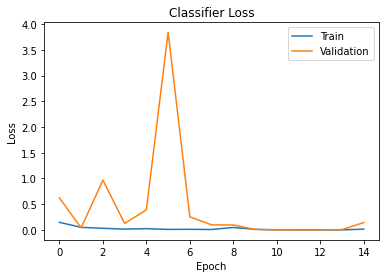

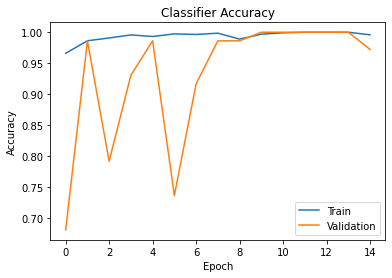

In [111]:
hist=history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='lower right')
plt.show()

In [112]:
################# Ideal Theshold Calculation ############################

y_prob=model.predict(X_test).ravel()
y_test1=np.array(y_test).ravel()

import numpy as np

def roc_curve(y_test1, y_prob, thresholds):

    fpr = []
    tpr = []
    
    for threshold in thresholds:

        y_pred = np.where(y_prob >= threshold, 1, 0)

        fp = np.sum((y_pred == 1) & (y_test1== 0))
        tp = np.sum((y_pred == 1) & (y_test1 == 1))

        fn = np.sum((y_pred == 0) & (y_test1 == 1))
        tn = np.sum((y_pred == 0) & (y_test1 == 0))

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))

    return [fpr, tpr]

y_prob1 = model.predict(X_test).ravel()
thresholds1= list(np.arange(-100, 100, 0.001))
[fpr1,tpr1]=roc_curve(y_test1,y_prob1, thresholds1)
thresholds1=np.array(thresholds1)
tpr1=np.array(tpr1)
fpr1=np.array(fpr1)
import pandas as pd
i = np.arange(len(tpr1)) 
roc1 = pd.DataFrame({'tf' : pd.Series(tpr1-(1-fpr1), index=i), 'thresholds1' : pd.Series(thresholds1, index=i)})
ideal_roc_thresh1 = roc1.iloc[(roc1.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh1['thresholds1'])

Ideal threshold is:  100001    0.001
Name: thresholds1, dtype: float64


In [113]:
############## Confusion Matrix Calculation###################

series_list=ideal_roc_thresh1['thresholds1'].tolist()
mythreshold=series_list[0]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve

y_prob=model.predict(X_test)
y_pred = (((y_prob)>= mythreshold).astype(int)).ravel()
print((type(y_pred)))

y_test1=np.array(y_test).ravel()
y_pred1=y_pred
cm=confusion_matrix(y_test1, y_pred1)    #################### Confusion Matrix
print(cm)

<class 'numpy.ndarray'>
[[55  0]
 [ 0 25]]


1.0


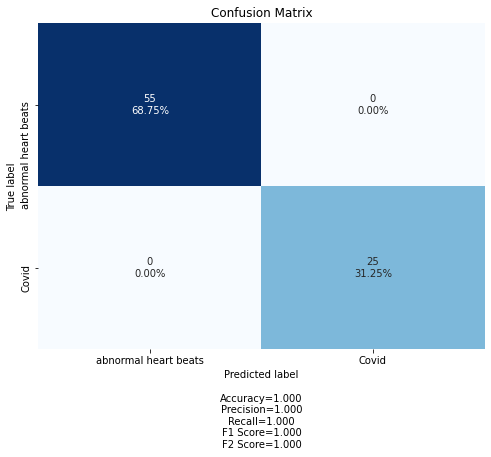

In [114]:
#################Confusion Metrics plot ###################################


from sklearn.metrics import confusion_matrix
from make_confusion_matrix import make_confusion_matrix
from calc_precision_recall import calc_precision_recall
TP,TN,FP,FN,precision, recall=calc_precision_recall(y_test, y_pred)

f2_score=(5*precision*recall) / ((4*precision) + recall)
print(f2_score)

cm=confusion_matrix(y_test_label,y_pred)
make_confusion_matrix(cm, figsize=(8,6), cbar=False,title="Confusion Matrix",categories=['abnormal heart beats',"Covid"])

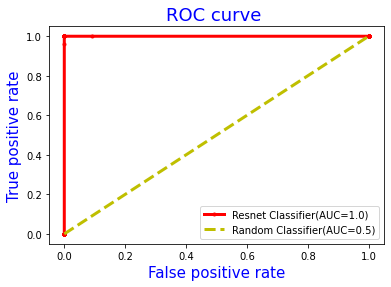

In [115]:
############################################### ROC Curve



plt.plot(fpr1, tpr1,linewidth=3, marker='.',color='Red')
plt.plot([0, 1], [0, 1], 'y--',linewidth=3)
plt.xlabel('False positive rate', fontsize=15, color='Blue')
plt.ylabel('True positive rate',fontsize=15,color='Blue')
plt.title('ROC curve ',fontsize=18,color='Blue')
plt.legend(['Resnet Classifier(AUC=1.0)','Random Classifier(AUC=0.5)'],loc='lower right', fontsize=10)
plt.show()


In [116]:
###### Inference Time #############################
Number_of_samples=len(y_test)
import time
start_time=time.time()
y_preds = model.predict(X_test)
total_time=time.time()-start_time
print(total_time)
# Inference Time
Inference=total_time/Number_of_samples
print(Inference)
# Frames Per Second                    
FPS=1/Inference
print(["FPS=",FPS])

print("Inference Time = ", Inference)
print("FPS = ", FPS)

0.06825613975524902
0.0008532017469406128
['FPS=', 1172.0557342806344]
Inference Time =  0.0008532017469406128
FPS =  1172.0557342806344


In [117]:
y_pred = (model.predict(X_test)>= mythreshold).astype(int)
TP,TN,FP,FN,precision, recall = calc_precision_recall(y_test, y_pred)
Accuracy=((TP+TN)/(TP+TN+FP+FN))*100
Sensitivity=(TP/(TP+FN))*100
Specificity=(TN/(TN+FP))*100
Precision=(TP/(TP+FP))*100
Recall= Sensitivity
f2_score=((5*Precision*Recall) / ((4*Precision) + Recall))/100


##################### AUC ################

y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test1, y_preds)
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)



import pandas as pd
# assign values to lists.  
data = [{'Model':'Model1','Accuracy': Accuracy,'Precision':Precision, 'Sensitivity': Sensitivity, 'Specificity':Specificity,'F2-score':f2_score,'ROC-AUC':auc_value}]  
  
# Creates DataFrame.  
df = pd.DataFrame(data)  
df.index+=1
# Print the data  
print(df)
print("Ideal threshold =", mythreshold)

    Model  Accuracy  Precision  Sensitivity  Specificity  F2-score  ROC-AUC
1  Model1     100.0      100.0        100.0        100.0       1.0      1.0
Ideal threshold = 0.0010000004774894933


In [118]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', 
show_shapes=True)